# RNA-seq analysis is hard as 1-2-3 with limma, Glimma and edgeR

This notebook implements the RNA-Seq analysis pipeline described at https://www.bioconductor.org/help/workflows/RNAseq123/ . It was transferred to Jupyter by Amanda Birmingham (CCBB).  

#### Requirements: 
Full functionality of this notebook requires R 3.3.1.  Most functionality (except for Glimma interactive plots) can be delivered for R 3.3.0.  `curl` must also be installed on the system.

## Authors

Charity Law(1), Monther Alhamdoosh(2), Shian Su(3), Gordon K. Smyth(4) and Matthew E. Ritchie(5)

1. The Walter and Eliza Hall Institute of Medical Research, 1G Royal Parade, Parkville, VIC 3052, Melbourne, Australia; Department of Medical Biology, The University of Melbourne, Parkville, VIC 3010, Melbourne, Australia
2. CSL Limited, Bio21 Institute, 30 Flemington Road, Parkville, Victoria 3010, Australia
3. The Walter and Eliza Hall Institute of Medical Research, 1G Royal Parade, Parkville, VIC 3052, Melbourne, Australia
4. The Walter and Eliza Hall Institute of Medical Research, 1G Royal Parade, Parkville, VIC 3052, Melbourne, Australia; School of Mathematics and Statistics, The University of Melbourne, Parkville, VIC 3010, Melbourne, Australia
5. The Walter and Eliza Hall Institute of Medical Research, 1G Royal Parade, Parkville, VIC 3052, Melbourne, Australia; Department of Medical Biology, The University of Melbourne, Parkville, VIC 3010, Melbourne, Australia; School of Mathematics and Statistics, The University of Melbourne, Parkville, VIC 3010, Melbourne, Australia

## Contents

* [Abstract](#Abstract)
* [Introduction](#Introduction)
* [Set-up](#Set-up)
* [Data packaging](#Data-packaging)
    * [Reading in count-data](#Reading-in-count-data)
    * [Organising sample information](#Organising-sample-information)
    * [Organising gene annotations](#Organising-gene-annotations)
* [Data pre-processing](#Data-pre-processing)
    * [Transformations from the raw-scale](#Transformations-from-the-raw-scale)
    * [Removing genes that are lowly expressed](#Removing-genes-that-are-lowly-expressed)
    * [Normalising gene expression distributions](#Normalising-gene-expression-distributions)
    * [Unsupervised clustering of samples](#Unsupervised-clustering-of-samples)
* [Differential expression analysis](#Differential-expression-analysis)
    * [Creating a design matrix and contrasts](#Creating-a-design-matrix-and-contrasts)
    * [Removing heteroscedascity from count data](#Removing-heteroscedascity-from-count-data)
    * [Fitting linear models for comparisons of interest](#Fitting-linear-models-for-comparisons-of-interest)
    * [Examining the number of DE genes](#Examining-the-number-of-DE-genes)
    * [Examining individual DE genes from top to bottom](#Examining-individual-DE-genes-from-top-to-bottom)
    * [Useful graphical representations of differential expression results](#Useful-graphical-representations-of-differential-expression-results)
* [Gene set testing with camera](#Gene-set-testing-with-camera)
* [Software and code used](#Software-and-code-used)
* [References](#References)


## Abstract

The ability to easily and efficiently analyse RNA-sequencing data is a key strength of the Bioconductor project. Starting with counts summarised at the gene-level, a typical analysis involves pre-processing, exploratory data analysis, differential expression testing and pathway analysis with the results obtained informing future experiments and validation studies. In this workflow article, we analyse RNA-sequencing data from the mouse mammary gland, demonstrating use of the popular edgeR package to import, organise, filter and normalise the data, followed by the limma package with its voom method, linear modelling and empirical Bayes moderation to assess differential expression and perform gene set testing. This pipeline is further enhanced by the Glimma package which enables interactive exploration of the results so that individual samples and genes can be examined by the user. The complete analysis offered by these three packages highlights the ease with which researchers can turn the raw counts from an RNA-sequencing experiment into biological insights using Bioconductor.
Introduction

RNA-sequencing (RNA-seq) has become the primary technology used for gene expression profiling, with the genome-wide detection of differentially expressed genes between two or more conditions of interest one of the most commonly asked questions by researchers. The edgeR (Robinson, McCarthy, and Smyth 2010) and limma packages (Ritchie et al. 2015) available from the Bioconductor project (Huber et al. 2015) offer a well-developed suite of statistical methods for dealing with this question for RNA-seq data.

In this article, we describe an edgeR - limma workflow for analysing RNA-seq data that takes gene-level counts as its input, and moves through pre-processing and exploratory data analysis before obtaining lists of differentially expressed (DE) genes and gene signatures. This analysis is enhanced through the use of interactive graphics from the Glimma package (Su and Ritchie 2016), that allows for a more detailed exploration of the data at both the sample and gene-level than is possible using static R plots.

The experiment analysed in this workflow is from Sheridan et al. (2015) (Sheridan et al. 2015) and consists of three cell populations (basal, luminal progenitor (LP) and mature luminal (ML)) sorted from the mammary glands of female virgin mice, each profiled in triplicate. RNA samples were sequenced across three batches on an Illumina HiSeq 2000 to obtain 100 base-pair single-end reads. The analysis outlined in this article assumes that reads obtained from an RNA-seq experiment have been aligned to an appropriate reference genome and summarised into counts associated with gene-specific regions. In this instance, reads were aligned to the mouse reference genome (mm10) using the R based pipeline available in the Rsubread package (specifically the align function (Liao, Smyth, and Shi 2013) followed by featureCounts (Liao, Smyth, and Shi 2014) for gene-level summarisation based on the in-built mm10 RefSeq-based annotation).

Count data for these samples can be downloaded from the Gene Expression Omnibus (GEO) http://www.ncbi.nlm.nih.gov/geo/ using GEO Series accession number GSE63310. Further information on experimental design and sample preparation is also available from GEO under this accession number.

## Set-up

### Installation

Note that the following packages have already been installed on the rnaseq123_docker image.  If this notebook is being run outside that environment, uncomment the cells below (i.e., delete the # at the beginning of each line) and run them to install the necessary libraries.

#### R packages

In [7]:
#install.packages("R.utils")
#install.packages("gplots")

#### Bioconductor 3.4

In [8]:
#source("http://bioconductor.org/biocLite.R")

If the above command reports a version of Bioconductor earlier than 3.4, some of the functionality of this notebook will be limited.  If you are running R version 3.3.1 or later, you can attempt to update to the latest Bioconductor version by uncommenting and running the upgrade command below:

In [9]:
#biocLite("BiocUpgrade")

If the command above reports "Error: Bioconductor version 3.4 cannot be upgraded with R version [whatever]", **GOOD**.  You already have Bioconductor 3.4 and this notebook should have full functionality.  Likewise, if it reports that it has **upgraded** to Bioconductor 3.4, this is also fine.  However, if it reports **nothing**, your Bioconductor version has not been upgraded; therefore, if that version is <3.4, some functionality in this notebook will be limited.

If you definitely have R 3.3.1 or above installed but are the upgrade is not working, **UNCOMMENT** the cell below and run it.  Then go to **Kernel** > **Restart** in the notebook menu, and agree to restart when asked.  Then rerun "source bioconductor" cell above; at this point, you should be upgraded to Bioconductor 3.4.

In [10]:
#remove.packages("BiocInstaller")

#### Bioconductor packages

In [11]:
#biocLite("limma")
#biocLite("edgeR")
#biocLite("Glimma")
#biocLite("Mus.musculus")

### Library Loading

In [12]:
library(IRdisplay)

In [13]:
library(limma)
library(edgeR)
library(Glimma)
library(Mus.musculus)

## Data packaging

#### Reading in count-data

To get started with this analysis, download the file GSE63310_RAW.tar available online from https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE63310&amp;format=file, and extract the relevant files from this archive. The code below will do this, or you can do this step manually and then move on.

In [14]:
# Note: original url is commented out below.  Accessing it gives a message that the 
# content formerly there has permanently moved to the new url shown further below.
# url <- "http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE63310&format=file"
url <- "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE63310&amp;format=file"
utils::download.file(url, destfile="GSE63310_RAW.tar", mode="wb") 
utils::untar("GSE63310_RAW.tar", exdir = ".", tar="internal")
files <- c("GSM1545535_10_6_5_11.txt", "GSM1545536_9_6_5_11.txt", "GSM1545538_purep53.txt",
  "GSM1545539_JMS8-2.txt", "GSM1545540_JMS8-3.txt", "GSM1545541_JMS8-4.txt",
  "GSM1545542_JMS8-5.txt", "GSM1545544_JMS9-P7c.txt", "GSM1545545_JMS9-P8c.txt")
for(i in paste(files, ".gz", sep=""))
  R.utils::gunzip(i, overwrite=TRUE)

Each of these text files contains the raw gene-level counts for a given sample. Note that our analysis only includes the basal, LP and ML samples from this experiment (see associated file names below).

In [15]:
files <- c("GSM1545535_10_6_5_11.txt", "GSM1545536_9_6_5_11.txt", 
   "GSM1545538_purep53.txt", "GSM1545539_JMS8-2.txt", 
   "GSM1545540_JMS8-3.txt", "GSM1545541_JMS8-4.txt", 
   "GSM1545542_JMS8-5.txt", "GSM1545544_JMS9-P7c.txt", 
   "GSM1545545_JMS9-P8c.txt")
read.delim(files[1], nrow=5)

EntrezID,GeneLength,Count
497097,3634,1
100503874,3259,0
100038431,1634,0
19888,9747,0
20671,3130,1


Whilst each of the nine text files can be read into R separately and combined into a matrix of counts, edgeR offers a convenient way to do this in one step using the readDGE function. The resulting DGEList-object contains a matrix of counts with 27,179 rows associated with unique Entrez gene identifiers (IDs) and nine columns associated with the individual samples in the experiment.

In [16]:
x <- readDGE(files, columns=c(1,3))
class(x)

# Note that the results of class shown in the notebook differ slightly from
# those shown directly from the R prompt:
# [1] "DGEList"
# attr(,"package")
# [1] "edgeR"

[1] "DGEList"
attr(,"package")
[1] "edgeR"

In [17]:
dim(x)

[1] 27179     9

If the counts from all samples were stored in a single file, the data can be read into R and then converted into a DGEList-object using the DGEList function.

#### Organising sample information

For downstream analysis, sample-level information related to the experimental design needs to be associated with the columns of the counts matrix. This should include experimental variables, both biological and technical, that could have an effect on expression levels. Examples include cell type (basal, LP and ML in this experiment), genotype (wild-type, knock-out), phenotype (disease status, sex, age), sample treatment (drug, control) and batch information (date experiment was performed if samples were collected and analysed at distinct time points) to name just a few.
Our DGEList-object contains a samples data frame that stores both cell type (or group) and batch (sequencing lane) information, each of which consists of three distinct levels. Note that within x$samples, library sizes are automatically calculated for each sample and normalisation factors are set to 1. For simplicity, we remove the GEO sample IDs (GSM*) from the column names of our DGEList-object x.

In [18]:
samplenames <- substring(colnames(x), 12, nchar(colnames(x)))
samplenames

[1] "10_6_5_11" "9_6_5_11"  "purep53"   "JMS8-2"    "JMS8-3"    "JMS8-4"   
[7] "JMS8-5"    "JMS9-P7c"  "JMS9-P8c"

In [19]:
colnames(x) <- samplenames
group <- as.factor(c("LP", "ML", "Basal", "Basal", "ML", "LP", 
                     "Basal", "ML", "LP"))
x$samples$group <- group
lane <- as.factor(rep(c("L004","L006","L008"), c(3,4,2)))
x$samples$lane <- lane
x$samples

,files,group,lib.size,norm.factors,lane
10_6_5_11,GSM1545535_10_6_5_11.txt,LP,32863052,1,L004
9_6_5_11,GSM1545536_9_6_5_11.txt,ML,35335491,1,L004
purep53,GSM1545538_purep53.txt,Basal,57160817,1,L004
JMS8-2,GSM1545539_JMS8-2.txt,Basal,51368625,1,L006
JMS8-3,GSM1545540_JMS8-3.txt,ML,75795034,1,L006
JMS8-4,GSM1545541_JMS8-4.txt,LP,60517657,1,L006
JMS8-5,GSM1545542_JMS8-5.txt,Basal,55086324,1,L006
JMS9-P7c,GSM1545544_JMS9-P7c.txt,ML,21311068,1,L008
JMS9-P8c,GSM1545545_JMS9-P8c.txt,LP,19958838,1,L008


#### Organising gene annotations

A second data frame named genes in the DGEList-object is used to store gene-level information associated with rows of the counts matrix. This information can be retrieved using organism specific packages such as Mus.musculus (Bioconductor Core Team 2016b) for mouse (or Homo.sapiens (Bioconductor Core Team 2016a) for human) or the biomaRt package (Durinck et al. 2005; Durinck et al. 2009) which interfaces the Ensembl genome databases in order to perform gene annotation.

The type of information that can be retrieved includes gene symbols, gene names, chromosome names and locations, Entrez gene IDs, Refseq gene IDs and Ensembl gene IDs to name just a few. biomaRt primarily works off Ensembl gene IDs, whereas Mus.musculus packages information from various sources and allows users to choose between many different gene IDs as the key.

The Entrez gene IDs available in our dataset were annotated using the Mus.musculus package to retrieve associated gene symbols and chromosome information.

In [20]:
geneid <- rownames(x)
genes <- select(Mus.musculus, keys=geneid, columns=c("SYMBOL", "TXCHROM"), 
                keytype="ENTREZID")
head(genes)

'select()' returned 1:many mapping between keys and columns


ENTREZID,SYMBOL,TXCHROM
497097,Xkr4,chr1
100503874,Gm19938,NA
100038431,Gm10568,NA
19888,Rp1,chr1
20671,Sox17,chr1
27395,Mrpl15,chr1


As with any gene ID, Entrez gene IDs may not map one-to-one to the gene information of interest. It is important to check for duplicated gene IDs and to understand the source of duplication before resolving them. Our gene annotation contains 28 genes that map to multiple chromosomes (e.g. gene Gm1987 is associated with chr4 and chr4_JH584294_random and microRNA Mir5098 is associated with chr2, chr5, chr8, chr11 and chr17). To resolve duplicate gene IDs one could combine all chromosome information from the multi-mapped genes, such that gene Gm1987 would be is assigned to chr4 and chr4_JH584294_random, or select one of the chromosomes to represent the gene with duplicate annotation. For simplicity we do the latter, keeping only the first occurrence of each gene ID.

In [21]:
genes <- genes[!duplicated(genes$ENTREZID),]

In this example, the gene order is the same in both the annotation and the data object. If this is not the case due to missing and/or rearranged gene IDs, the match function can be used to order genes correctly. The data frame of gene annotations is then added to the data object and neatly packaged in a DGEList-object containing raw count data with associated sample information and gene annotations.

In [22]:
x$genes <- genes
x

An object of class "DGEList"
$samples
                             files group lib.size norm.factors lane
10_6_5_11 GSM1545535_10_6_5_11.txt    LP 32863052            1 L004
9_6_5_11   GSM1545536_9_6_5_11.txt    ML 35335491            1 L004
purep53     GSM1545538_purep53.txt Basal 57160817            1 L004
JMS8-2       GSM1545539_JMS8-2.txt Basal 51368625            1 L006
JMS8-3       GSM1545540_JMS8-3.txt    ML 75795034            1 L006
JMS8-4       GSM1545541_JMS8-4.txt    LP 60517657            1 L006
JMS8-5       GSM1545542_JMS8-5.txt Basal 55086324            1 L006
JMS9-P7c   GSM1545544_JMS9-P7c.txt    ML 21311068            1 L008
JMS9-P8c   GSM1545545_JMS9-P8c.txt    LP 19958838            1 L008

$counts
           Samples
Tags        10_6_5_11 9_6_5_11 purep53 JMS8-2 JMS8-3 JMS8-4 JMS8-5 JMS9-P7c
  497097            1        2     342    526      3      3    535        2
  100503874         0        0       5      6      0      0      5        0
  100038431         0        0       0      0      0      0      1        0
  19888             0        1       0      0     17      2      0        1
  20671             1        1      76     40     33     14     98       18
           Samples
Tags        JMS9-P8c
  497097           0
  100503874        0
  100038431        0
  19888            0
  20671            8
27174 more rows ...

$genes
   ENTREZID  SYMBOL TXCHROM
1    497097    Xkr4    chr1
2 100503874 Gm19938    <NA>
3 100038431 Gm10568    <NA>
4     19888     Rp1    chr1
5     20671   Sox17    chr1
27174 more rows ...

## Data pre-processing

#### Transformations from the raw-scale

For differential expression and related analyses, gene expression is rarely considered at the level of raw counts since libraries sequenced at a greater depth will result in higher counts. Rather, it is common practice to transform raw counts onto a scale that accounts for such library size differences. Popular transformations include counts per million (CPM), log2-counts per million (log-CPM), reads per kilobase of transcript per million (RPKM), and fragments per kilobase of transcript per million (FPKM).

In our analyses, CPM and log-CPM transformations are used regularly although they do not account for feature length differences which RPKM and FPKM values do. Whilst RPKM and FPKM values can just as well be used, CPM and log-CPM values can be calculated using a counts matrix alone and will suffice for the type of comparisons we are interested in. Assuming that there are no differences in isoform usage between conditions, differential expression analyses look at gene expression changes between conditions rather than comparing expression across multiple genes or drawing conclusions on absolute levels of expression. In other words, gene lengths remain constant for comparisons of interest and any observed differences are a result of changes in condition rather than changes in gene length.

Here raw counts are converted to CPM and log-CPM values using the cpm function in edgeR, where log-transformations use a prior count of 0.25 to avoid taking the log of zero. RPKM values are just as easily calculated as CPM values using the rpkm function in edgeR if gene lengths are available.

In [23]:
cpm <- cpm(x)
lcpm <- cpm(x, log=TRUE)

#### Removing genes that are lowly expressed

All datasets will include a mix of genes that are expressed and those that are not expressed. Whilst it is of interest to examine genes that are expressed in one condition but not in another, some genes are unexpressed throughout all samples. In fact, 19% of genes in this dataset have zero counts across all nine samples.

In [24]:
table(rowSums(x$counts==0)==9)


FALSE  TRUE 
22026  5153 

Genes that are not expressed at a biologically meaningful level in any condition should be discarded to reduce the subset of genes to those that are of interest, and to reduce the number of tests carried out downstream when looking at differential expression. Upon examination of log-CPM values, it can be seen that a large proportion of genes within each sample is unexpressed or lowly-expressed (shown in panel A of the next figure). Using a nominal CPM value of 1 (which is equivalent to a log-CPM value of 0) genes are deemed to be expressed if their expression is above this threshold, and unexpressed otherwise. Genes must be expressed in at least one group (or in at least three samples across the entire experiment) to be kept for downstream analysis.

Although any sensible value can be used as the expression cutoff, typically a CPM value of 1 is used in our analyses as it separates expressed genes from unexpressed genes well for most datasets. Here, a CPM value of 1 means that a gene is expressed if it has at least 20 counts in the sample with the lowest sequencing depth (JMS9-P8c, library size approx. 20 million) or at least 76 counts in the sample with the greatest sequencing depth (JMS8-3, library size approx. 76 million). If sequence reads are summarised by exons rather than genes and/or experiments have low sequencing depth, a lower CPM cutoff may be considered.

In [25]:
keep.exprs <- rowSums(cpm>1)>=3
x <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(x)

[1] 14165     9

Using this criterion, the number of genes is reduced to approximately half the number that we started with (14,165 genes, panel B of the next figure). Note that subsetting the entire DGEList-object removes both the counts as well as the associated gene information. Code to produce the figure is given below.

In [26]:
# This cell supports future resizing of the plots in the Jupyter notebook
defaultWidth = getOption("repr.plot.width")
defaultHeight = getOption("repr.plot.height")

In [27]:
# This cell resizes the output for attractive side-by-side plots
options(repr.plot.width=defaultWidth, repr.plot.height=defaultHeight*.7) 

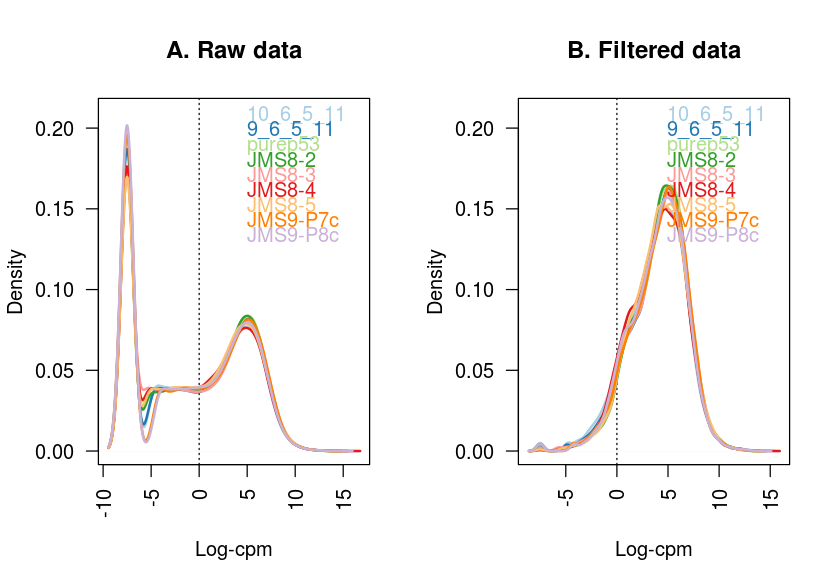

In [28]:
library(RColorBrewer)
nsamples <- ncol(x)
col <- brewer.pal(nsamples, "Paired")
par(mfrow=c(1,2))
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2, 
     main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=0, lty=3)
for (i in 2:nsamples){
 den <- density(lcpm[,i])
 lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")
lcpm <- cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2, 
     main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=0, lty=3)
for (i in 2:nsamples){
   den <- density(lcpm[,i])
   lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

The density of log-CPM values for raw pre-filtered data (A) and post-filtered data (B) are shown for each sample. Dotted vertical lines mark the log-CPM of zero threshold (equivalent to a CPM value of 1) used in the filtering step.

#### Normalising gene expression distributions

During the sample preparation or sequencing process, external factors that are not of biological interest can affect the expression of individual samples. For example, samples processed in the first batch of an experiment can have higher expression overall when compared to samples processed in a second batch. It is assumed that all samples should have a similar range and distribution of expression values. Normalisation is required to ensure that the expression distributions of each sample are similar across the entire experiment.

Any plot showing the per sample expression distributions, such as a density or boxplot, is useful in determining whether any samples are dissimilar to others. Distributions of log-CPM values are similar throughout all samples within this dataset (panel B of the figure above).

Nonetheless, normalisation by the method of trimmed mean of M-values (TMM) (Robinson and Oshlack 2010) is performed using the calcNormFactors function in edgeR. The normalisation factors calculated here are used as a scaling factor for the library sizes. When working with DGEList-objects, these normalisation factors are automatically stored in x$samples$norm.factors. For this dataset the effect of TMM-normalisation is mild, as evident in the magnitude of the scaling factors, which are all relatively close to 1.

In [29]:
x <- calcNormFactors(x, method = "TMM")
x$samples$norm.factors

[1] 0.8957309 1.0349196 1.0439552 1.0405040 1.0323599 0.9223424 0.9836603
[8] 1.0827381 0.9792607

To give a better visual representation of the effects of normalisation, the data was duplicated then adjusted so that the counts of the first sample are reduced to 5% of their original values, and in the second sample they are inflated to be 5-times larger.

In [30]:
x2 <- x
x2$samples$norm.factors <- 1
x2$counts[,1] <- ceiling(x2$counts[,1]*0.05)
x2$counts[,2] <- x2$counts[,2]*5

The figure below shows the expression distribution of samples for unnormalised and normalised data, where distributions are noticeably different pre-normalisation and are similar post-normalisation. Here the first sample has a small TMM scaling factor of 0.05, whereas the second sample has a large scaling factor of 6.13 – neither values are close to 1.

[1] 0.05472223 6.13059440 1.22927355 1.17051887 1.21487709 1.05622968 1.14587663
[8] 1.26129350 1.11702264

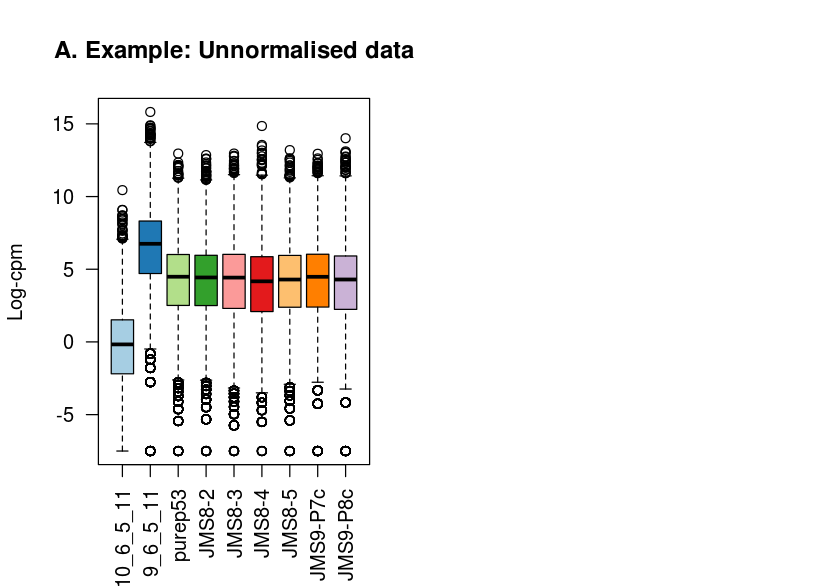

In [31]:
par(mfrow=c(1,2))
lcpm <- cpm(x2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="A. Example: Unnormalised data",ylab="Log-cpm")
x2 <- calcNormFactors(x2)  
x2$samples$norm.factors

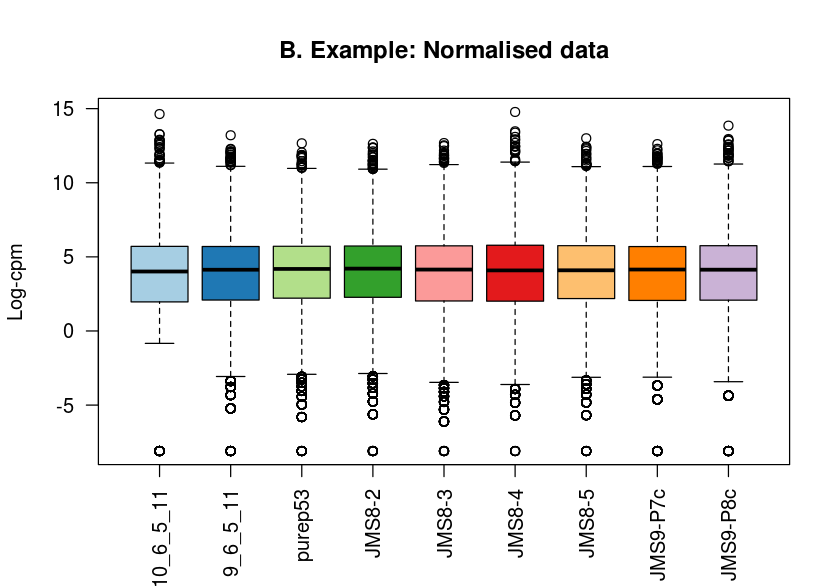

In [32]:
lcpm <- cpm(x2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="B. Example: Normalised data",ylab="Log-cpm")

Example data: Boxplots of log-CPM values showing expression distributions for unnormalised data (A) and normalised data (B) for each sample in the modified dataset where the counts in samples 1 and 2 have been scaled to 5% and 500% of their original values respectively.

#### Unsupervised clustering of samples

In our opinion, one of the most important exploratory plots to examine for gene expression analyses is the multi-dimensional scaling (MDS) plot, or similar. The plot shows similarities and dissimilarities between samples in an unsupervised manner so that one can have an idea of the extent to which differential expression can be detected before carrying out formal tests. Ideally, samples would cluster well within the primary condition of interest, and any sample straying far from its group could be identified and followed up for sources of error or extra variation. If present, technical replicates should lie very close to one another.

Such a plot can be made in limma using the plotMDS function. The first dimension represents the leading-fold-change that best separates samples and explains the largest proportion of variation in the data, with subsequent dimensions having a smaller effect and being orthogonal to the ones before it. When experimental design involves multiple factors, it is recommended that each factor is examined over several dimensions. If samples cluster by a given factor in any of these dimensions, it suggests that the factor contributes to expression differences and is worth including in the linear modelling. On the other hand, factors that show little or no effect may be left out of downstream analysis.

In this dataset, samples can be seen to cluster well within experimental groups over dimension 1 and 2, and then separate by sequencing lane (sample batch) over dimension 3 (shown in the plot below). Keeping in mind that the first dimension explains the largest proportion of variation in the data, notice that the range of values over the dimensions become smaller as we move to higher dimensions.

Whilst all samples cluster by groups, the largest transcriptional difference is observed between basal and LP, and basal and ML over dimension 1. For this reason, it is expected that pairwise comparisons between cell populations will result in a greater number of DE genes for comparisons involving basal samples, and relatively small numbers of DE genes when comparing ML to LP. In other datasets, samples that do not cluster by their groups of interest may also show little or no evidence of differential expression in the downstream analysis.
To create the MDS plots, different colour groupings are assigned to factors of interest. Dimensions 1 and 2 are examined using the color grouping defined by cell types.

Dimensions 3 and 4 are examined using the colour grouping defined by sequencing lanes (batch).

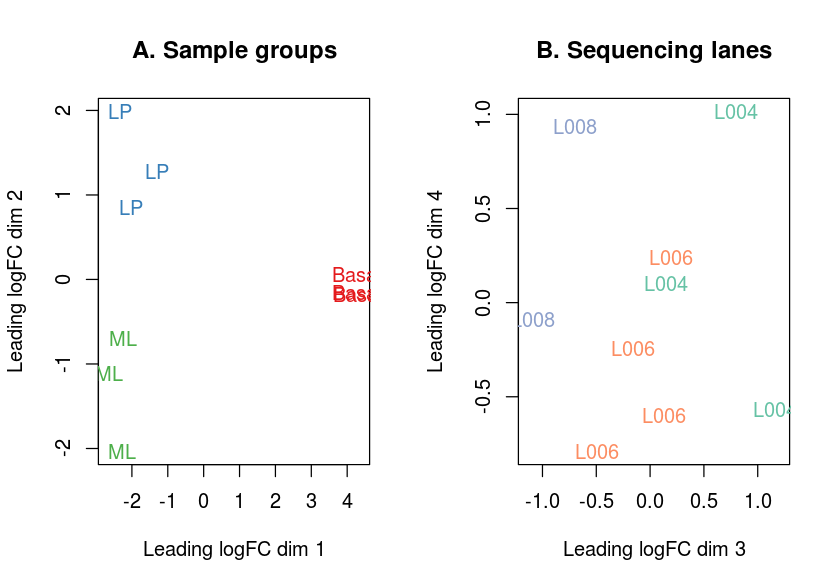

In [33]:
lcpm <- cpm(x, log=TRUE)
par(mfrow=c(1,2))
col.group <- group
levels(col.group) <-  brewer.pal(nlevels(col.group), "Set1")
col.group <- as.character(col.group)
col.lane <- lane
levels(col.lane) <-  brewer.pal(nlevels(col.lane), "Set2")
col.lane <- as.character(col.lane)
plotMDS(lcpm, labels=group, col=col.group)
title(main="A. Sample groups")
plotMDS(lcpm, labels=lane, col=col.lane, dim=c(3,4))
title(main="B. Sequencing lanes")

MDS plots of log-CPM values over dimensions 1 and 2 with samples coloured and labeled by sample groups (A) and over dimensions 3 and 4 with samples coloured and labeled by sequencing lane (B). Distances on the plot correspond to the leading fold-change, which is the average (root-mean-square) log2-fold-change for the 500 genes most divergent between each pair of samples by default.

Alternatively, the Glimma package offers the convenience of an interactive MDS plot where multiple dimensions can be explored. The glMDSPlot function generates an html page (that is opened in a browser if launch=TRUE) with an MDS plot in the left panel and a barplot showing the proportion of variation explained by each dimension in the right panel. Clicking on the bars of the bar plot changes the pair of dimensions plotted in the MDS plot, and hovering over the individual points reveals the sample label. The colour scheme can be changed as well to highlight cell population or sequencing lane (batch). An interactive MDS plot of this dataset can be found at http://bioinf.wehi.edu.au/folders/limmaWorkflow/glimma-plots/MDS-Plot.html.

In [34]:
# NB: If you are running Bioconductor 3.3 instead of 3.4, this command
# WILL NOT WORK.

glMDSPlot(lcpm, labels=paste(group, lane, sep="_"), 
          groups=x$samples[,c(2,5)])

In [35]:
IRdisplay::display_html("<a href='./glimma-plots/MDS-Plot.html' target='_newtab'>Click</a> to see MDS-Plot in new tab.")

Click to see MDS-Plot in new tab.

## Differential expression analysis

#### Creating a design matrix and contrasts

In this study, it is of interest to see which genes are expressed at different levels between the three cell populations profiled. In our analysis, linear models are fitted to the data with the assumption that the underlying data is normally distributed. To get started, a design matrix is set up with both the cell population and sequencing lane (batch) information.

In [36]:
design <- model.matrix(~0+group+lane)
colnames(design) <- gsub("group", "", colnames(design))
design

# R console output also includes
## attr(,"assign")
## [1] 1 1 1 2 2
## attr(,"contrasts")
## attr(,"contrasts")$group
## [1] "contr.treatment"
## 
## attr(,"contrasts")$lane
## [1] "contr.treatment"

,Basal,LP,ML,laneL006,laneL008
1,0,1,0,0,0
2,0,0,1,0,0
3,1,0,0,0,0
4,1,0,0,1,0
5,0,0,1,1,0
6,0,1,0,1,0
7,1,0,0,1,0
8,0,0,1,0,1
9,0,1,0,0,1


For a given experiment, there are usually several equivalent ways to set up an appropriate design matrix. For example, ~0+group+lane removes the intercept from the first factor, group, but an intercept remains in the second factor lane. Alternatively, ~group+lane could be used to keep the intercepts in both group and lane. Understanding how to interpret the coefficients estimated in a given model is key here. We choose the first model for our analysis, as setting up model contrasts is more straight forward in the absence of an intercept for group. Contrasts for pairwise comparisons between cell populations are set up in limma using the makeContrasts function.

In [37]:
contr.matrix <- makeContrasts(
   BasalvsLP = Basal-LP, 
   BasalvsML = Basal - ML, 
   LPvsML = LP - ML, 
   levels = colnames(design))
contr.matrix

,BasalvsLP,BasalvsML,LPvsML
Basal,1,1,0
LP,-1,0,1
ML,0,-1,-1
laneL006,0,0,0
laneL008,0,0,0


A key strength of limma’s linear modelling approach, is the ability accommodate arbitrary experimental complexity. Simple designs, such as the one in this workflow, with cell type and batch, through to more complicated factorial designs and models with interaction terms can be handled relatively easily. Where experimental or technical effects can be modelled using a random effect, another possibility in limma is to estimate correlations using duplicateCorrelation by specifying a block argument for both this function and in the lmFit linear modelling step.

#### Removing heteroscedascity from count data

It has been shown that for RNA-seq count data, the variance is not independent of the mean (Law et al. 2014) – this is true of raw counts or when transformed to log-CPM values. Methods that model counts using a Negative Binomial distribution assume a quadratic mean-variance relationship. In limma, linear modelling is carried out on the log-CPM values which are assumed to be normally distributed and the mean-variance relationship is accommodated using precision weights calculated by the voom function.

When operating on a DGEList-object, voom converts raw counts to log-CPM values by automatically extracting library sizes and normalisation factors from x itself. Additional normalisation to log-CPM values can be specified within voom using the normalize.method argument.

The mean-variance relationship of log-CPM values for this dataset is shown in the left-hand panel of the next figure. Typically, the voom-plot shows a decreasing trend between the means and variances resulting from a combination of technical variation in the sequencing experiment and biological variation amongst the replicate samples from different cell populations. Experiments with high biological variation usually result in flatter trends, where variance values plateau at high expression values. Experiments with low biological variation tend to result in sharp decreasing trends.

Moreover, the voom-plot provides a visual check on the level of filtering performed upstream. If filtering of lowly-expressed genes is insufficient, a drop in variance levels can be observed at the low end of the expression scale due to very small counts. If this is observed, one should return to the earlier filtering step and increase the expression threshold applied to the dataset.

Where sample-level variation is evident from earlier inspections of the MDS plot, the voomWithQualityWeights function can be used to simultaneously incorporate sample-level weights together with the abundance dependent weights estimated by voom (Liu et al. 2015). For an example of this, see Liu et al. (2016) (Liu et al. 2016).

,ENTREZID,SYMBOL,TXCHROM
1,497097,Xkr4,chr1
6,27395,Mrpl15,chr1
7,18777,Lypla1,chr1
9,21399,Tcea1,chr1
10,58175,Rgs20,chr1
11,108664,Atp6v1h,chr1
14,12421,Rb1cc1,chr1
17,319263,Pcmtd1,chr1
19,59014,Rrs1,chr1
20,76187,Adhfe1,chr1


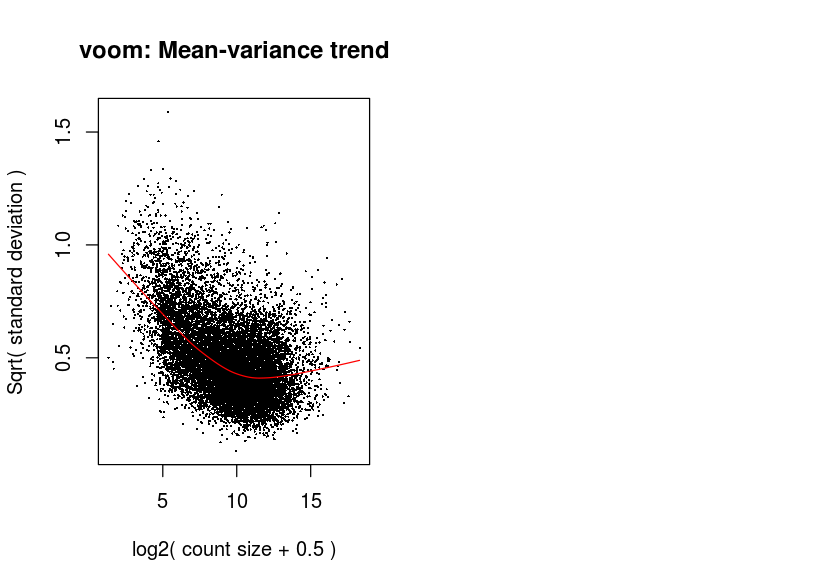

In [38]:
par(mfrow=c(1,2))
v <- voom(x, design, plot=TRUE)
v

In [39]:
# This cell sets the output graphic size back to the Jupyter notebook defaults
options(repr.plot.width=defaultWidth, repr.plot.height=defaultHeight) 

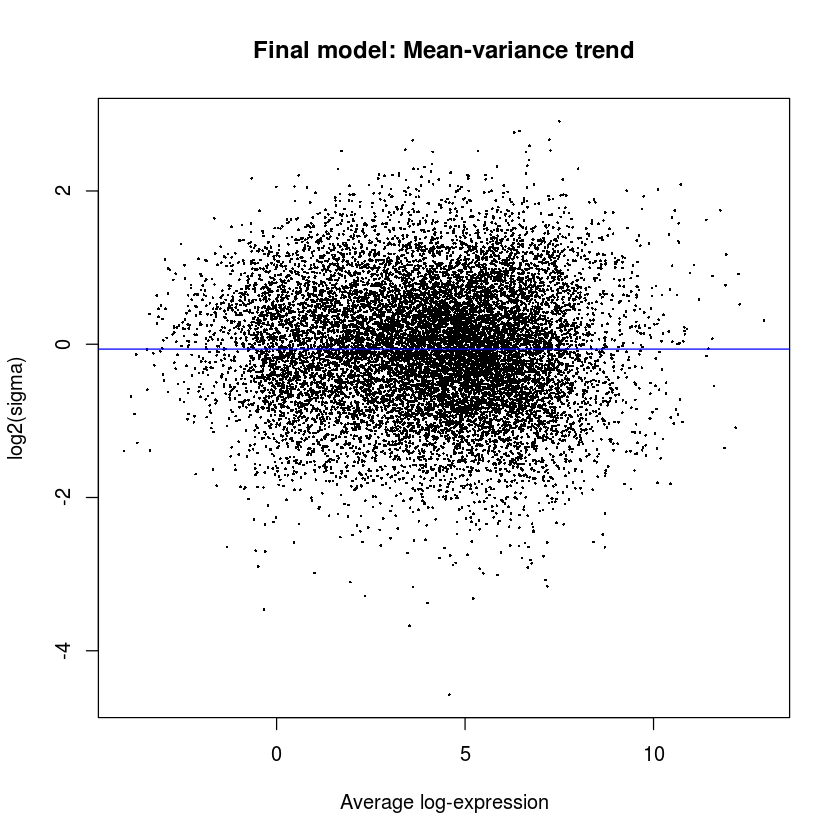

In [40]:
vfit <- lmFit(v, design)
vfit <- contrasts.fit(vfit, contrasts=contr.matrix)
efit <- eBayes(vfit)
plotSA(efit, main="Final model: Mean-variance trend")

Note that the other data frames stored within the DGEList-object that contain gene- and sample-level information, are retained in the EList-object v created by voom. The v\$genes data frame is equivalent to x\$genes, v\$targets is equivalent to x\$samples, and the expression values stored in v\$E is analogous to x\$counts, albeit on a transformed scale. In addition to this, the voom EList-object has a matrix of precision weights v\$weights and stores the design matrix in v\$design.

#### Fitting linear models for comparisons of interest

Linear modelling in limma is carried out using the lmFit and contrasts.fit functions originally written for application to microarrays. The functions can be used for both microarray and RNA-seq data and fit a separate model to the expression values for each gene. Next, empirical Bayes moderation is carried out by borrowing information across all the genes to obtain more precise estimates of gene-wise variability (Smyth 2004). The model’s residual variances are plotted against average expression values in the next figure. It can be seen from this plot that the variance is no longer dependent on the mean expression level.

#### Examining the number of DE genes

For a quick look at differential expression levels, the number of significantly up- and down-regulated genes can be summarised in a table. Significance is defined using an adjusted p-value cutoff that is set at 5% by default. For the comparison between expression levels in basal and LP, 4,127 genes are found to be down-regulated in basal relative to LP and 4,298 genes are up-regulated in basal relative to LP – a total of 8,425 DE genes. A total of 8,510 DE genes are found between basal and ML (4,338 down- and 4,172 up-regulated genes), and a total of 5,340 DE genes are found between LP and ML (2,895 down- and 2,445 up-regulated). The larger numbers of DE genes observed for comparisons involving the basal population are consistent with our observations from the MDS plots.

In [41]:
summary(decideTests(efit))

   BasalvsLP BasalvsML LPvsML
-1      4127      4338   2895
0       5740      5655   8825
1       4298      4172   2445

Some studies require more than an adjusted p-value cut-off. For a stricter definition on significance, one may require log-fold-changes (log-FCs) to be above a minimum value. The treat method (McCarthy and Smyth 2009) can be used to calculate p-values from empirical Bayes moderated t-statistics with a minimum log-FC requirement. The number of differentially expressed genes are reduced to a total of 3,135 DE genes for basal versus LP, 3,270 DE genes for basal versus ML, and 385 DE genes for LP versus ML when testing requires genes to have a log-FC that is significantly greater than 1 (equivalent to a 2-fold difference between cell types on the original scale).

In [42]:
tfit <- treat(vfit, lfc=1)
dt <- decideTests(tfit)
summary(dt)

   BasalvsLP BasalvsML LPvsML
-1      1417      1512    203
0      11030     10895  13780
1       1718      1758    182

Genes that are DE in multiple comparisons can be extracted using the results from decideTests, where 0s represent genes that are not DE, 1s represent genes that are up-regulated, and -1s represent genes that are down-regulated. A total of 2,409 genes are DE in both basal versus LP and basal versus ML, twenty of which are listed below. The write.fit function can be used to extract and write results for all three comparisons to a single output file.

In [43]:
de.common <- which(dt[,1]!=0 & dt[,2]!=0)
length(de.common)

[1] 2409

In [44]:
head(tfit$genes$SYMBOL[de.common], n=20)

[1] "Xkr4"          "Rgs20"         "Cpa6"          "Sulf1"        
 [5] "Eya1"          "Msc"           "Sbspon"        "Pi15"         
 [9] "Crispld1"      "Kcnq5"         "Ptpn18"        "Arhgef4"      
[13] "2010300C02Rik" "Aff3"          "Npas2"         "Tbc1d8"       
[17] "Creg2"         "Il1r1"         "Il18r1"        "Il18rap"

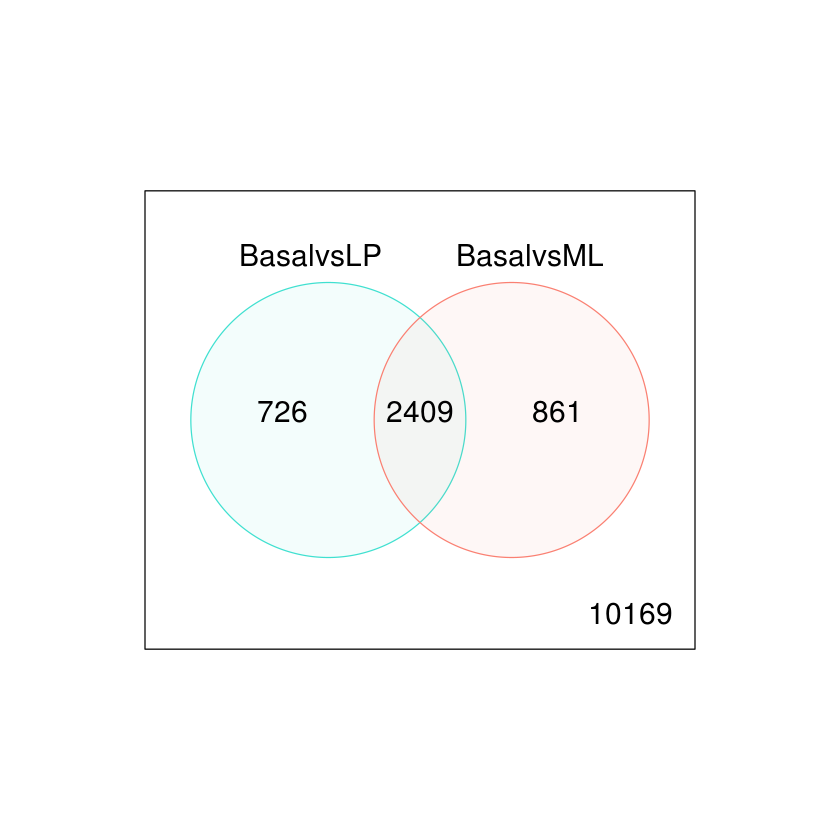

In [45]:
vennDiagram(dt[,1:2], circle.col=c("turquoise", "salmon"))

Venn diagram showing the number of genes DE in the comparison between basal versus LP only (left), basal versus ML only (right), and the number of genes that are DE in both comparisons (center). The number of genes that are not DE in either comparison are marked in the bottom-right.

In [46]:
write.fit(tfit, dt, file="results.txt")

#### Examining individual DE genes from top to bottom

The top DE genes can be listed using topTreat for results using treat (or topTable for results using eBayes). By default topTreat arranges genes from smallest to largest adjusted p-value with associated gene information, log-FC, average log-CPM, moderated t-statistic, raw and adjusted p-value for each gene. The number of top genes displayed can be specified, where n=Inf includes all genes. Genes Cldn7 and Rasef are amongst the top DE genes for both basal versus LP and basal versus ML.

In [47]:
basal.vs.lp <- topTreat(tfit, coef=1, n=Inf)
basal.vs.ml <- topTreat(tfit, coef=2, n=Inf)
head(basal.vs.lp)

,ENTREZID,SYMBOL,TXCHROM,logFC,AveExpr,t,P.Value,adj.P.Val
12759,12759,Clu,chr14,-5.442877,8.857907,-33.44429,3.990899e-10,2.703871e-06
53624,53624,Cldn7,chr11,-5.514605,6.296762,-32.94533,4.503694e-10,2.703871e-06
242505,242505,Rasef,chr4,-5.921741,5.119585,-31.77625,6.063249e-10,2.703871e-06
67451,67451,Pkp2,chr16,-5.724823,4.420495,-30.65370,8.010456e-10,2.703871e-06
228543,228543,Rhov,chr2,-6.253427,5.486640,-29.46244,1.112729e-09,2.703871e-06
70350,70350,Basp1,chr15,-6.073297,5.248349,-28.64890,1.380545e-09,2.703871e-06


In [48]:
head(basal.vs.ml)

,ENTREZID,SYMBOL,TXCHROM,logFC,AveExpr,t,P.Value,adj.P.Val
242505,242505,Rasef,chr4,-6.510470,5.119585,-35.49093,2.573575e-10,1.915485e-06
53624,53624,Cldn7,chr11,-5.469160,6.296762,-32.52520,4.978446e-10,1.915485e-06
12521,12521,Cd82,chr2,-4.667737,7.070963,-31.82187,5.796191e-10,1.915485e-06
71740,71740,Nectin4,chr1,-5.556046,5.166292,-31.29987,6.760578e-10,1.915485e-06
20661,20661,Sort1,chr3,-4.908119,6.705784,-31.23083,6.761331e-10,1.915485e-06
15375,15375,Foxa1,chr12,-5.753884,5.625064,-28.34612,1.487280e-09,2.281914e-06


#### Useful graphical representations of differential expression results

To summarise results for all genes visually, mean-difference plots, which display log-FCs from the linear model fit against the average log-CPM values can be generated using the plotMD function, with the differentially expressed genes highlighted.

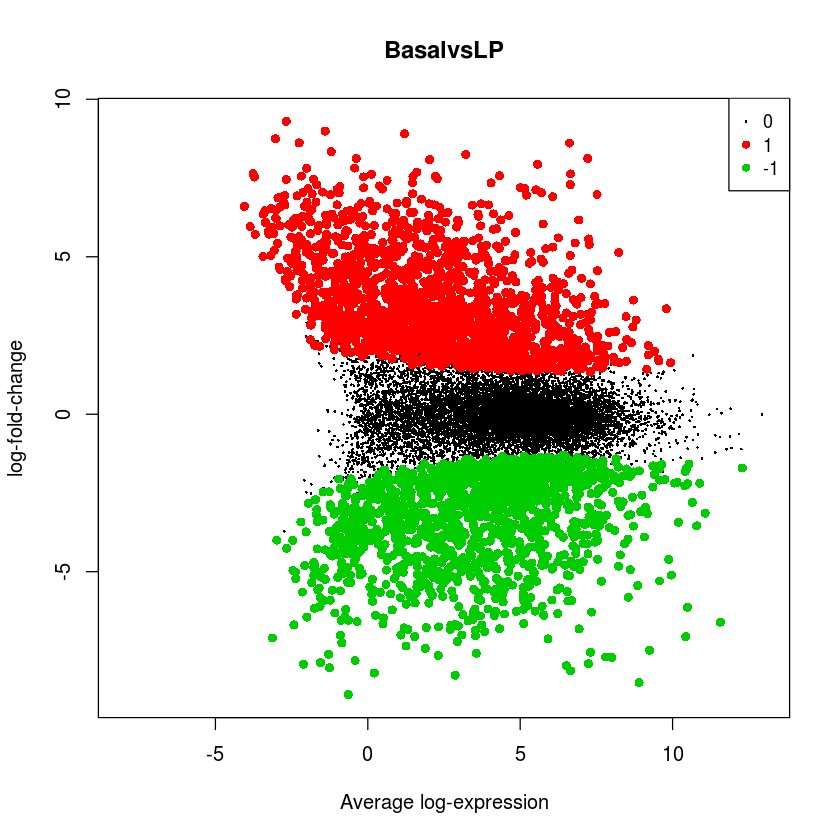

In [49]:
plotMD(tfit, column=1, status=dt[,1], main=colnames(tfit)[1], 
       xlim=c(-8,13))

Glimma extends this functionality by providing an interactive mean-difference plot via the glMDPlot function. The output of this function is an html page, with summarised results in the left panel (similar to what is output by plotMD), and the log-CPM values from individual samples in the right panel, with a table of results below the plots. This interactive display allows the user to search for particular genes based on their Gene symbol, which is not possible in a static R plot. The glMDPlot function is not limited to mean-difference plots, with a default version allowing a data frame to be passed with the user able to select the columns of interest to plot in the left panel.

In [50]:
# NB: If you are running Bioconductor 3.3 instead of 3.4, this command
# WILL NOT WORK.

glMDPlot(tfit, coef=1, status=dt, main=colnames(tfit)[1],
         id.column="ENTREZID", counts=x$counts, groups=group)

In [51]:
IRdisplay::display_html("<a href='./glimma-plots/MD-Plot.html' target='_newtab'>Click</a> to see MD-Plot in new tab.")

Click to see MD-Plot in new tab.

Interactive mean-difference plot generated using Glimma. Summary data (log-FCs versus log-CPM values) are shown in the left panel which is linked to the individual values per sample for a selected gene in the right panel. A table of results is also displayed below these figures, along with a search bar to allow users to look up a particular gene using the annotation information available, e.g. the Gene symbol identifier Clu.

The mean-difference plot generated by the command above is available online (see http://bioinf.wehi.edu.au/folders/limmaWorkflow/glimma-plots/MD-Plot.html). The interactivity provided by the Glimma package allows additional information to be presented in a single graphical window. Glimma is implemented in R and Javascript, with the R code generating the data which is converted into graphics using the Javascript library D3 (https://d3js.org), with the Bootstrap library handling layouts and Datatables generating the interactive searchable tables. This allows plots to be viewed in any modern browser, which is convenient for including them as linked files from an Rmarkdown report of the analysis.

Plots shown previously include either all of the genes that are expressed in any one condition (such as the Venn diagram of common DE genes or mean-difference plot) or look at genes individually (log-CPM values shown in right panel of the interactive mean-difference plot). Heatmaps allow users to look at the expression of a subset of genes. This can be give useful insight into the expression of individual groups and samples without losing perspective of the overall study when focusing on individual genes, or losing resolution when examining patterns averaged over thousands of genes at the same time.

A heatmap is created for the top 100 DE genes (as ranked by adjusted p-value) from the basal versus LP contrast using the heatmap.2 function from the gplots package. The heatmap correctly clusters samples into cell type and rearranges the order of genes to form blocks of similar expression. From the heatmap, we observe that the expression of ML and LP samples are very similar for the top 100 DE genes between basal and LP.

In [52]:
# This cell sets the output graphic size to be taller
options(repr.plot.width=defaultWidth, repr.plot.height=defaultHeight*1.5) 


Attaching package: ‘gplots’

The following object is masked from ‘package:IRanges’:

    space

The following object is masked from ‘package:S4Vectors’:

    space

The following object is masked from ‘package:stats’:

    lowess



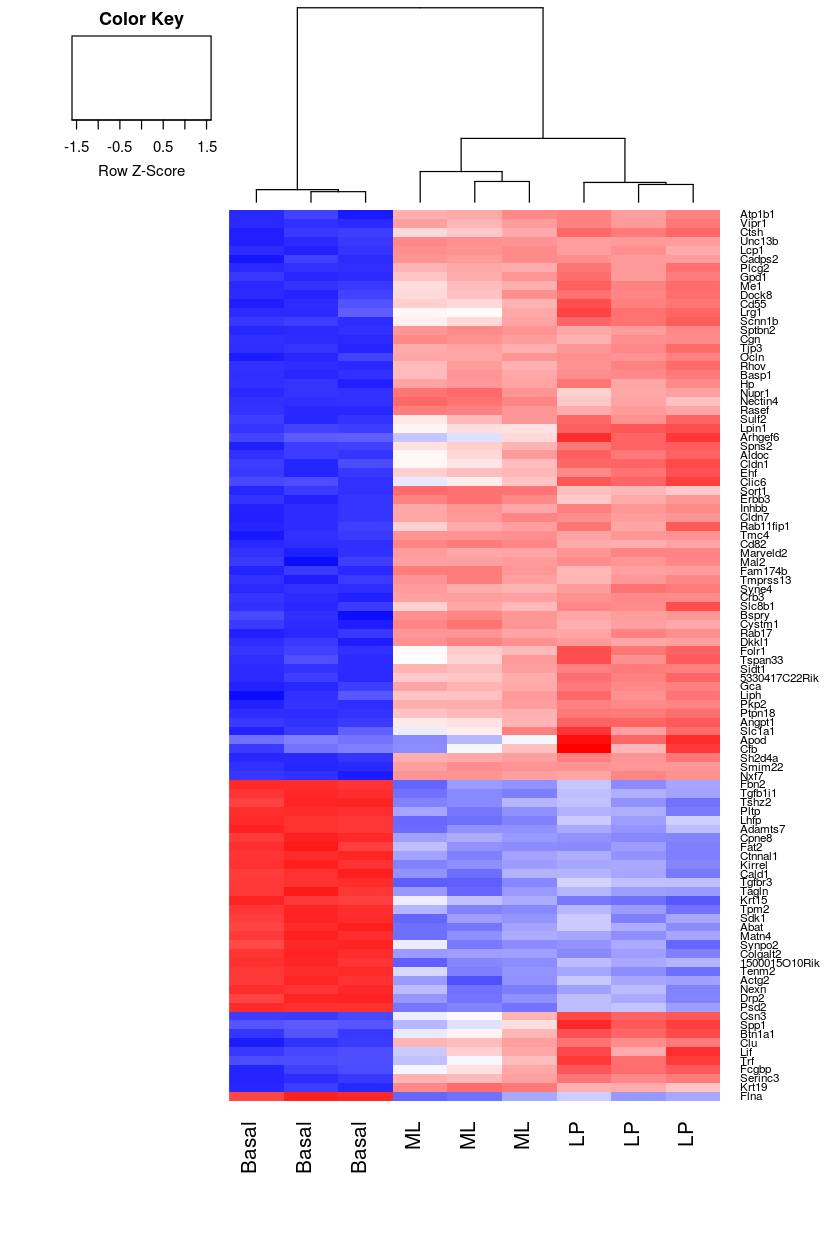

In [53]:
library(gplots)
basal.vs.lp.topgenes <- basal.vs.lp$ENTREZID[1:100]
i <- which(v$genes$ENTREZID %in% basal.vs.lp.topgenes)
mycol <- colorpanel(1000,"blue","white","red")
heatmap.2(v$E[i,], scale="row",
   labRow=v$genes$SYMBOL[i], labCol=group, 
   col=mycol, trace="none", density.info="none", 
   margin=c(8,6), lhei=c(2,10), dendrogram="column")

Heatmap of log-CPM values for top 100 genes DE in basal versus LP. Expression across each gene (or row) have been scaled so that mean expression is zero and standard deviation is one. Samples with relatively high expression of a given gene are marked in red and samples with relatively low expression are marked in blue. Lighter shades and white represent genes with intermediate expression levels. Samples and genes have been reordered by the method of hierarchical clustering. A dendrogram is shown for the sample clustering.

## Gene set testing with camera

We finish off this analysis with some gene set testing by applying the camera method (Wu and Smyth 2012) to the c2 gene signatures from Broad Institute’s MSigDB c2 collection (Subramanian et al. 2005) that have been adapted for mouse and are available as Rdata objects from http://bioinf.wehi.edu.au/software/MSigDB/. Other useful gene sets derived from MSigDB for both human and mouse, such as the hallmark gene sets, are also available from this site. C2 gene sets have been curated from online databases, publications and domain experts, and hallmark gene sets are selected from MSigDB to have well-defined biological states or processes.

In [54]:
load("../mouse_c2_v5p1.rda")
idx <- ids2indices(Mm.c2,id=rownames(v))
cam.BasalvsLP <- camera(v,idx,design,contrast=contr.matrix[,1])
head(cam.BasalvsLP,5)

Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '../mouse_c2_v5p1.rda', probable reason 'No such file or directory'”

ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


In [ ]:
cam.BasalvsML <- camera(v,idx,design,contrast=contr.matrix[,2])
head(cam.BasalvsML,5)

In [ ]:
cam.LPvsML <- camera(v,idx,design,contrast=contr.matrix[,3])
head(cam.LPvsML,5)

The camera function performs a competitive test to assess whether the genes in a given set are highly ranked in terms of differential expression relative to genes that are not in the set. It uses limma’s linear model framework, taking both the design matrix and contrast matrix (if present) and accommodates the observational-level weights from voom in the testing procedure. After adjusting the variance of the resulting gene set test statistic by a variance inflation factor, that depends on the gene-wise correlation (which is set to 0.01 by default, but can be estimated from the data) and the size of the set, a p-value is returned and adjusted for multiple testing.

This experiment is the RNA-seq equivalent of Lim et al. (2010) (Lim et al. 2010), who used Illumina microarrays to profile the same sorted cell populations, so it is reassuring to see the gene signatures from this earlier publication coming up at the top of the list for each contrast. We make a barcodeplot of the Lim et al. (2010) Mature Luminal gene sets (Up and Down) in the LP versus ML contrast. Note that these sets go in the opposite direction in our dataset due to our parameterization which compares LP against ML rather than the other way around (if the contrast were reversed, the directions would be consistent).

In [ ]:
# This cell sets the output graphic size back to the defaults
options(repr.plot.width=defaultWidth, repr.plot.height=defaultHeight) 

In [ ]:
barcodeplot(efit$t[,3], index=idx$LIM_MAMMARY_LUMINAL_MATURE_UP, 
            index2=idx$LIM_MAMMARY_LUMINAL_MATURE_DN, main="LPvsML")

Barcode plot of LIM_MAMMARY_LUMINAL_MATURE_UP (red bars, top of plot) and LIM_MAMMARY_LUMINAL_MATURE_DN (blue bars, bottom of plot) gene sets in the LP versus ML contrast with an enrichment line for each set that shows the relative enrichment of the vertical bars in each part of the plot. The experiment of Lim et al. (Lim et al. 2010) is very similar to the current one, with the same sorting strategy used to obtain the different cell populations, except that microarrays were used instead of RNA-seq to profile gene expression. Note that the inverse correlation (the up gene set is down and the down gene set is up) is a result of the way the contrast has been set up (LP versus ML) – if reversed, the directionality would agree.

Other gene set tests are available in limma, such as the self-contained tests by mroast (Wu et al. 2010). Whilst camera is ideal for testing a large database of gene sets and observing which of them rank highly relative to others (as shown above), self-contained tests are better for focused testing of one or a few specifically chosen sets to see if they are DE in their own right. In other words, camera is more appropriate when ‘fishing’ for gene sets of interest, whereas mroast tests sets that are already of interest for significance.

## Software and code used

This RNA-seq workflow makes use of various packages available from version 3.4 of the Bioconductor project, running on R version 3.3.0 or higher. Besides the software highlighted in this article (limma, Glimma and edgeR) it requires a number of other packages, including gplots and RColorBrewer and the gene annotation package Mus.musculus. This document was compiled using knitr. Version numbers for all packages used are shown below. Code to perform this analysis is available in the Bioconductor workflow package RNAseq123 from http://www.bioconductor.org/help/workflows/RNAseq123/.

In [ ]:
sessionInfo()

## References

Bioconductor Core Team. 2016a. Homo.sapiens: Annotation package for the Homo.sapiens object. https://bioconductor.org/packages/release/data/annotation/html/Homo.sapiens.html.

———. 2016b. Mus.musculus: Annotation package for the Mus.musculus object. https://bioconductor.org/packages/release/data/annotation/html/Mus.musculus.html.

Durinck, S., Y. Moreau, A. Kasprzyk, S. Davis, B. De Moor, A. Brazma, and W. Huber. 2005. “BioMart and Bioconductor: a powerful link between biological databases and microarray data analysis.” Bioinformatics 21: 3439–40.

Durinck, S., P. Spellman, E. Birney, and W. Huber. 2009. “Mapping identifiers for the integration of genomic datasets with the R/Bioconductor package biomaRt.” Nature Protocols 4: 1184–91.

Huber, W., V. J. Carey, R. Gentleman, S. Anders, M. Carlson, B. S. Carvalho, H. C. Bravo, et al. 2015. “Orchestrating High-Throughput Genomic Analysis with Bioconductor.” Nature Methods 12 (2): 115–21. http://www.nature.com/nmeth/journal/v12/n2/full/nmeth.3252.html.

Law, C. W., Y. Chen, W. Shi, and G. K. Smyth. 2014. “Voom: Precision Weights Unlock Linear Model Analysis Tools for RNA-seq Read Counts.” Genome Biology 15: R29.

Liao, Y., G. K. Smyth, and W. Shi. 2013. “The Subread Aligner: Fast, Accurate and Scalable Read Mapping by Seed-and-Vote.” Nucleic Acids Res 41 (10): e108.

———. 2014. “featureCounts: an Efficient General-Purpose Program for Assigning Sequence Reads to Genomic Features.” Bioinformatics 30 (7): 923–30.

Lim, E., D. Wu, B. Pal, T. Bouras, M. L. Asselin-Labat, F. Vaillant, H. Yagita, G. J. Lindeman, G. K. Smyth, and J. E. Visvader. 2010. “Transcriptome analyses of mouse and human mammary cell subpopulations reveal multiple conserved genes and pathways.” Breast Cancer Research 12 (2): R21.

Liu, R., K. Chen, N. Jansz, M. E. Blewitt, and M. E. Ritchie. 2016. “Transcriptional Profiling of the Epigenetic Regulator Smchd1.” Genomics Data 7: 144–7.

Liu, R., A. Z. Holik, S. Su, N. Jansz, K. Chen, H. S. Leong, M. E. Blewitt, M. L. Asselin-Labat, G. K. Smyth, and M. E. Ritchie. 2015. “Why weight? Combining voom with estimates of sample quality improves power in RNA-seq analyses.” Nucleic Acids Res 43: e97.

McCarthy, D. J., and G. K. Smyth. 2009. “Testing significance relative to a fold-change threshold is a TREAT.” Bioinformatics 25: 765–71.

Ritchie, M. E., B. Phipson, D. Wu, Y. Hu, C. W. Law, W. Shi, and G. K. Smyth. 2015. “limma Powers Differential Expression Analyses for RNA-Sequencing and Microarray Studies.” Nucleic Acids Res 43 (7): e47.

Robinson, M. D., and A. Oshlack. 2010. “A Scaling Normalization Method for Differential Expression Analysis of RNA-seq data.” Genome Biology 11: R25.

Robinson, M. D., D. J. McCarthy, and G. K. Smyth. 2010. “edgeR: A Bioconductor Package for Differential Expression Analysis of Digital Gene Expression Data.” Bioinformatics 26: 139–40.

Sheridan, J. M., M. E. Ritchie, S. A. Best, K. Jiang, T. J. Beck, F. Vaillant, K. Liu, et al. 2015. “A pooled shRNA screen for regulators of primary mammary stem and progenitor cells identifies roles for Asap1 and Prox1.” BMC Cancer 15 (1). BioMed Central: 221.

Smyth, G. K. 2004. “Linear Models and Empirical Bayes Methods for Assessing Differential Expression in Microarray Experiments.” Stat Appl Genet Mol Biol 3 (1): Article 3.

Su, S., and M. E. Ritchie. 2016. Glimma: Interactive HTML graphics for RNA-seq data. https://bioconductor.org/packages/devel/bioc/html/Glimma.html.

Subramanian, A., P. Tamayo, V. K. Mootha, S. Mukherjee, B. L. Ebert, M. A. Gillette, A. Paulovich, et al. 2005. “Gene Set Enrichment Analysis: A Knowledge-Based Approach for Interpreting Genome-Wide Expression Profiles.” Proc Natl Acad Sci U S A 102 (43): 15545–50.

Wu, D., and G. K. Smyth. 2012. “Camera: a competitive gene set test accounting for inter-gene correlation.” Nucleic Acids Res 40 (17): e133.

Wu, D., E. Lim, F. Vaillant, M. L. Asselin-Labat, J. E. Visvader, and G. K. Smyth. 2010. “ROAST: rotation gene set tests for complex microarray experiments.” Bioinformatics 26 (17): 2176–82.